In [1]:
from dotenv import load_dotenv
import os
from langchain_groq import ChatGroq
load_dotenv()

os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")

llm = ChatGroq(model="qwen/qwen3-32b")

d:\Tranining_Code\AI_builder_Program_New\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from langchain_core.tools import tool

@tool
def get_text_length(text: str) -> int:
    "Return the length of a text by character"
    text = text.strip("'\n").strip(
        '"'
    )  # stripping away non alphabetic characters just in case
    return len(text)

In [3]:
get_text_length.invoke("Hello how are you")

17

In [4]:
tools = [get_text_length]

In [5]:
template = """
    Answer the following questions as best you can. You have access to the following tools:

    {tools}
    
    Use the following format:
    
    Question: the input question you must answer
    Thought: you should always think about what to do
    Action: the action to take, should be one of [{tool_names}]
    Action Input: the input to the action
    Observation: the result of the action
    ... (this Thought/Action/Action Input/Observation can repeat N times)
    Thought: I now know the final answer
    Final Answer: the final answer to the original input question
    
    Begin!
    
    Question: {input}
    Thought:
    """


In [6]:
from langchain_core.prompts import PromptTemplate
from langchain_core.tools import Tool, render_text_description
prompt = PromptTemplate(template=template).partial(tools=render_text_description(tools), tool_names=", ".join([tool.name for tool in tools]))

- `tools=render_text_description(tools)`
This part takes a list of your tool objects and formats them into a detailed, human-readable block of text. This description tells the LLM what each tool does.

- `tool_names=", ".join([t.name for t in tools])`
This part creates a simple, comma-separated string containing only the names of the available tools. This list tells the LLM the exact names it must use when it decides to call a tool.

In [7]:
llm = ChatGroq(model="qwen/qwen3-32b",stop=["\nObservation", "Observation"],temperature=0 )


In [ ]:
from langchain.agents.output_parsers import ReActSingleInputOutputParser
agent = prompt | llm | ReActSingleInputOutputParser()

In [14]:
agent.invoke("What is the length of 'DOG' in characters?",)

AgentAction(tool='get_text_length', tool_input="'DOG'\n", log="<think>\nOkay, I need to find the length of the text 'DOG' in characters. Let me think. The user provided a tool called get_text_length that returns the length of a text by character. So I should use that tool. The action input would be the string 'DOG'. Let me check if there's any other steps needed. No, I think that's straightforward. Just call get_text_length with 'DOG' as the input.\n</think>\n\nThought: I need to determine the number of characters in the string 'DOG'. Since the tool get_text_length is available, I can use it directly.\n\nAction: get_text_length\nAction Input: 'DOG'\n")

In [15]:
from langchain_core.agents import AgentAction, AgentFinish
from typing import List, Union

agent_step: Union[AgentAction, AgentFinish] = agent.invoke(
        {
            "input": "What is the length of 'DOG' in characters?",
        }
    )

In [16]:
def find_tool_by_name(tools: List[Tool], tool_name: str) -> Tool:
    for tool in tools:
        if tool.name == tool_name:
            return tool
    raise ValueError(f"Tool not found: {tool_name}")


In [17]:
if isinstance(agent_step, AgentAction):
        tool_name = agent_step.tool
        tool_to_use = find_tool_by_name(tools, tool_name)
        tool_input = agent_step.tool_input

        observation = tool_to_use.func(str(tool_input))
        print(f"{observation=}")

observation=3


## React Agent

In [18]:
from typing import Annotated,Sequence, TypedDict
from langchain_core.messages import BaseMessage
from langgraph.graph.message import add_messages  # helper function to add messages to the state

class AgentState(TypedDict):
    """The state of the agent."""
    messages: Annotated[Sequence[BaseMessage], add_messages]
    number_of_steps: int

In [27]:
from langchain_core.tools import tool
model = ChatGroq(model="qwen/qwen3-32b" )

@tool
def get_weather(location: str):
    """Call to get the weather from a specific location."""
    # This is a placeholder for the actual implementation
    # Don't let the LLM know this though 😊
    if any([city in location.lower() for city in ["sf", "san francisco"]]):
        return "It's sunny in San Francisco."
    else:
        return f"I am not sure what the weather is in {location}"


tools = [get_weather]

model = model.bind_tools(tools)

In [28]:
res=model.invoke(f"What is the weather in san francisco")


In [29]:
res

AIMessage(content='', additional_kwargs={'reasoning_content': 'Okay, the user is asking for the weather in San Francisco. I need to use the get_weather function they provided. Let me check the function\'s parameters. The function requires a "location" parameter, which is a string. San Francisco is the location here. I should make sure to format the city name correctly, maybe use "San Francisco" with the capital S and F. No other parameters are needed. I\'ll construct the tool call with the name "get_weather" and the arguments as {"location": "San Francisco"}. Let me double-check if there are any other requirements, but looks like that\'s all. Alright, ready to send the tool call.\n', 'tool_calls': [{'id': '2p3hpyg06', 'function': {'arguments': '{"location":"San Francisco"}', 'name': 'get_weather'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 160, 'prompt_tokens': 157, 'total_tokens': 317, 'completion_time': 0.343838047, 'prompt_time': 0.006714676, 'qu

## Define nodes and edges
Next let's define our nodes and edges. In our basic ReAct agent there are only two nodes, one for calling the model and one for using tools, however you can modify this basic structure to work better for your use case. The tool node we define here is a simplified version of the prebuilt ToolNode, which has some additional features.

Perhaps you want to add a node for adding structured output or a node for executing some external action (sending an email, adding a calendar event, etc.). Maybe you just want to change the way the call_model node works and how should_continue decides whether to call tools - the possibilities are endless and LangGraph makes it easy to customize this basic structure for your specific use case.

In [30]:
import json
from langchain_core.messages import ToolMessage, SystemMessage
from langchain_core.runnables import RunnableConfig

tools_by_name = {tool.name: tool for tool in tools}


In [31]:
tools_by_name

{'get_weather': StructuredTool(name='get_weather', description='Call to get the weather from a specific location.', args_schema=<class 'langchain_core.utils.pydantic.get_weather'>, func=<function get_weather at 0x0000012ADD293380>)}

In [32]:
# Define our tool node
def tool_node(state: AgentState):
    outputs = []
    for tool_call in state["messages"][-1].tool_calls:
        tool_result = tools_by_name[tool_call["name"]].invoke(tool_call["args"])
        outputs.append(
            ToolMessage(
                content=json.dumps(tool_result),
                name=tool_call["name"],
                tool_call_id=tool_call["id"],
            )
        )
    return {"messages": outputs}


# Define the node that calls the model
def call_model(
    state: AgentState,
    config: RunnableConfig,
):
    # this is similar to customizing the create_react_agent with 'prompt' parameter, but is more flexible
    system_prompt = SystemMessage(
        "You are a helpful AI assistant, please respond to the users query to the best of your ability!"
    )
    response = model.invoke([system_prompt] + state["messages"], config)
    # We return a list, because this will get added to the existing list
    return {"messages": [response]}


# Define the conditional edge that determines whether to continue or not
def should_continue(state: AgentState):
    messages = state["messages"]
    last_message = messages[-1]
    # If there is no function call, then we finish
    if not last_message.tool_calls:
        return "end"
    # Otherwise if there is, we continue
    else:
        return "continue"


## Define the graph
Now that we have defined all of our nodes and edges, we can define and compile our graph. Depending on if you have added more nodes or different edges, you will need to edit this to fit your specific use case.

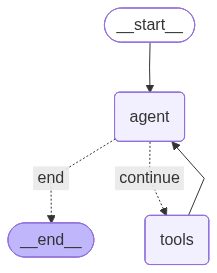

In [33]:
from langgraph.graph import StateGraph, END

# Define a new graph
workflow = StateGraph(AgentState)

# Define the two nodes we will cycle between
workflow.add_node("agent", call_model)
workflow.add_node("tools", tool_node)

# Set the entrypoint as `agent`
# This means that this node is the first one called
workflow.set_entry_point("agent")

# We now add a conditional edge
workflow.add_conditional_edges(
    # First, we define the start node. We use `agent`.
    # This means these are the edges taken after the `agent` node is called.
    "agent",
    # Next, we pass in the function that will determine which node is called next.
    should_continue,
    # Finally we pass in a mapping.
    # The keys are strings, and the values are other nodes.
    # END is a special node marking that the graph should finish.
    # What will happen is we will call `should_continue`, and then the output of that
    # will be matched against the keys in this mapping.
    # Based on which one it matches, that node will then be called.
    {
        # If `tools`, then we call the tool node.
        "continue": "tools",
        # Otherwise we finish.
        "end": END,
    },
)

# We now add a normal edge from `tools` to `agent`.
# This means that after `tools` is called, `agent` node is called next.
workflow.add_edge("tools", "agent")

# Now we can compile and visualize our graph
graph = workflow.compile()

from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [ ]:
def print_stream(stream):
    for s in stream:
        message = s["messages"][-1]
        if isinstance(message, tuple):
            print(message)
        else:
            message.pretty_print()


inputs = {"messages": [("user", "what is the weather in sf")]}
print_stream(graph.stream(inputs, stream_mode="values"))

================================ Human Message =================================

what is the weather in sf
================================== Ai Message ==================================
Tool Calls:
  get_weather (0j6x0jpqp)
 Call ID: 0j6x0jpqp
  Args:
    location: San Francisco
================================= Tool Message =================================
Name: get_weather

"It's sunny in San Francisco."
================================== Ai Message ==================================

The weather in San Francisco is sunny right now! ☀️ Let me know if you'd like more details. Enjoy your day!


: 